# Торговая система на основе комбинации PSAR, фракталов и ATR: оптимизация и тестирование на криптовалютном рынке
### **Лямин А.Д.** | Анализ финансовых рынков (Технический анализ) | Факультет экономических наук, НИУ ВШЭ
### Исходный код стратегии: [Репозиторий GitHub](Репозиторий) 

В работе представлена разработка и эмпирическая оценка торговой системы, использующей комбинацию трех технических индикаторов: параболического SAR (PSAR), фракталов Билла Вильямса и среднего истинного диапазона (ATR). Система реализована на языке `Python` с использованием библиотек для финансового анализа. Оптимизация параметров проводилась на периоде с января 2022 по декабрь 2024 года с применением фреймворка `Optuna`. Тестирование осуществлялось на независимом периоде с января 2025 года.

Для анализа использовались дневные данные по Bitcoin (BTC-USD) за период с 1 января 2022 года по 10 июля 2025 года. Данные получены через `API Yahoo Finance`. Общий объем выборки составляет 1287 торговых дней. Выбор криптовалюты в качестве базового актива обусловлен:
- Высокой ликвидностью рынка
- Непрерывностью торгов (24/7)
- Отсутствием дивидендных выплат, упрощающим анализ

In [1]:
import sys

sys.path.append("..")

In [2]:
from matplotlib import pyplot as plt

from src import (
    Config,
    DataLoader,
    TradingStrategy,
    ParameterOptimizer,
    PerformanceMetrics,
    StrategyVisualizer,
)

In [3]:
# Загрузка данных
loader = DataLoader(Config.TICKER)
data = loader.get_data()

Загрузка данных для BTC-USD...


[*********************100%***********************]  1 of 1 completed

Данные загружены: 1462 дней (2021-12-02 - 2025-12-02)
Разделение данных:
   Train: 1096 дней (2022-01-01 - 2024-12-31)
   Test:  336 дней (2025-01-01 - 2025-12-02)


# Индикаторы

### **Parabolic SAR (PSAR)**

Параболический SAR разработан Дж. Уэллсом Уайлдером-младшим. Индикатор генерирует точки (Stop and Reverse), расположенные ниже цены при восходящем тренде и выше цены при нисходящем. Формально, значение PSAR на момент $t$ вычисляется как:

\begin{equation}
SAR_t = SAR_{t-1} + AF \times (EP - SAR_{t-1})
\end{equation}

где $AF$ — фактор ускорения (начальное значение 0.02, увеличивается на 0.02 при каждом новом экстремуме до максимума 0.20), $EP$ — экстремальная цена (максимум для бычьего тренда, минимум для медвежьего).

### **Фракталы Билла Вильямса**

Фракталы идентифицируют локальные максимумы и минимумы на основе паттерна из пяти свечей. Для фрактала максимума:

\begin{equation}
\begin{aligned}
&High_t > High_{t-2} \\
&High_t > High_{t-1} \\
&High_t > High_{t+1} \\
&High_t > High_{t+2}
\end{aligned}
\end{equation}

Аналогично для фрактала минимума:

\begin{equation}
\begin{aligned}
&Low_t < Low_{t-2} \\
&Low_t < Low_{t-1} \\
&Low_t < Low_{t+1} \\
&Low_t < Low_{t+2}
\end{aligned}
\end{equation}

### **Average True Range (ATR)**

ATR измеряет волатильность рынка, учитывая гэпы между свечами. Истинный диапазон (True Range) определяется как:

\begin{equation}
TR_t = \max(High_t - Low_t, |High_t - Close_{t-1}|, |Low_t - Close_{t-1}|)
\end{equation}

ATR представляет собой скользящее среднее TR за период $N$:

\begin{equation}
ATR_t = \frac{1}{N}\sum_{i=t-N+1}^{t} TR_i
\end{equation}

# Стратегия

Система работает по следующим правилам:

- Вход в позицию (`Long`):
\begin{equation}
(Close_t > PSAR_t) and (ATR_t > SMA(ATR, M)_t) and (Close_t > FractalLow_{t-1})
\end{equation}

- Выход из позиции:

\begin{equation}
Close_t < PSAR_t or has FractalHigh_t
\end{equation}

где $SMA(ATR, M)$ — простое скользящее среднее ATR за период $M$.

In [4]:
# Инициализация стратегии с параметрами по умолчанию
strategy = TradingStrategy()
results, trades = strategy.run(data)

# Оптимизация

Для оптимизации параметров использовался фреймворк `Optuna`.

Целевая функция — максимизация коэффициента Шарпа, рассчитываемого как:

\begin{equation}
Sharpe = \frac{\bar{R} \times \sqrt{252}}{\sigma_R}
\end{equation}

где $\bar{R}$ — средняя дневная доходность, $\sigma_R$ — стандартное отклонение дневной доходности.

Период оптимизации: 1 января 2022 — 31 декабря 2024 (756 торговых дней). Проведено 50 итераций оптимизации.

In [5]:
optimizer = ParameterOptimizer(data["train"])
best_params = optimizer.optimize(n_trials=30, show_progress=True)

[I 2025-12-03 02:15:07,468] A new study created in memory with name: no-name-c6595c15-5d3c-4f67-84fc-204861ca5754


Оптимизация параметров стратегии...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-12-03 02:15:07,497] Trial 0 finished with value: 1.4730784796020764 and parameters: {'psar_af': 0.01749080237694725, 'psar_max': 0.2901428612819832, 'atr_period': 18, 'atr_sma_period': 24}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-03 02:15:07,510] Trial 1 finished with value: 0.8983135142352795 and parameters: {'psar_af': 0.01312037280884873, 'psar_max': 0.13119890406724052, 'atr_period': 10, 'atr_sma_period': 28}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-03 02:15:07,523] Trial 2 finished with value: 0.9719427441714489 and parameters: {'psar_af': 0.022022300234864175, 'psar_max': 0.2416145155592091, 'atr_period': 10, 'atr_sma_period': 30}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-03 02:15:07,535] Trial 3 finished with value: 1.2821625842417494 and parameters: {'psar_af': 0.026648852816008435, 'psar_max': 0.14246782213565523, 'atr_period': 12, 'atr_sma_period': 17}. Best is trial 0 with value: 1.4730784796020764.
[I 2025-12-0

In [6]:
# Стратегия с оптимальными параметрами
strategy = TradingStrategy(best_params)
results, trades = strategy.run(data)

In [7]:
# Визуализация
visualizer = StrategyVisualizer()

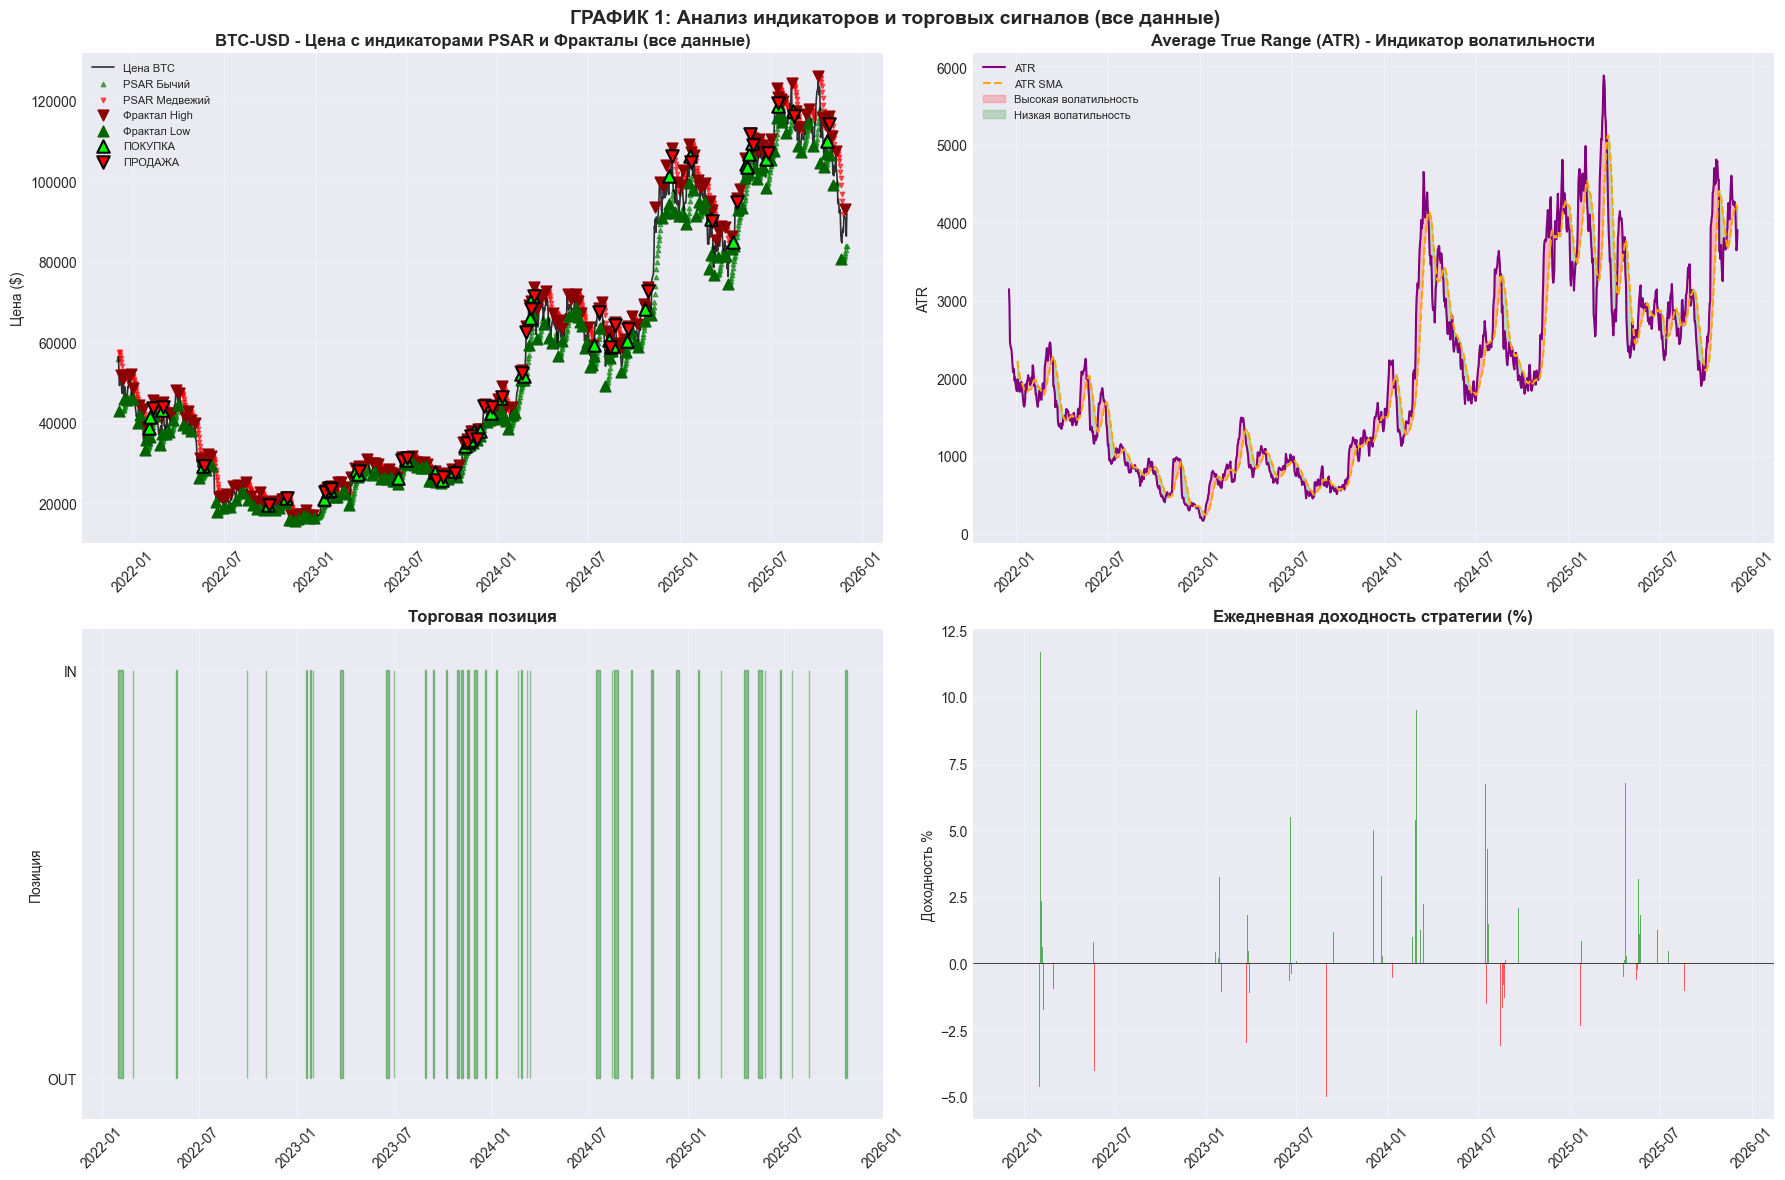

In [8]:
# График 1 для полных данных
fig1 = visualizer.plot_indicators_and_signals(results["full"], "(все данные)")
plt.show()

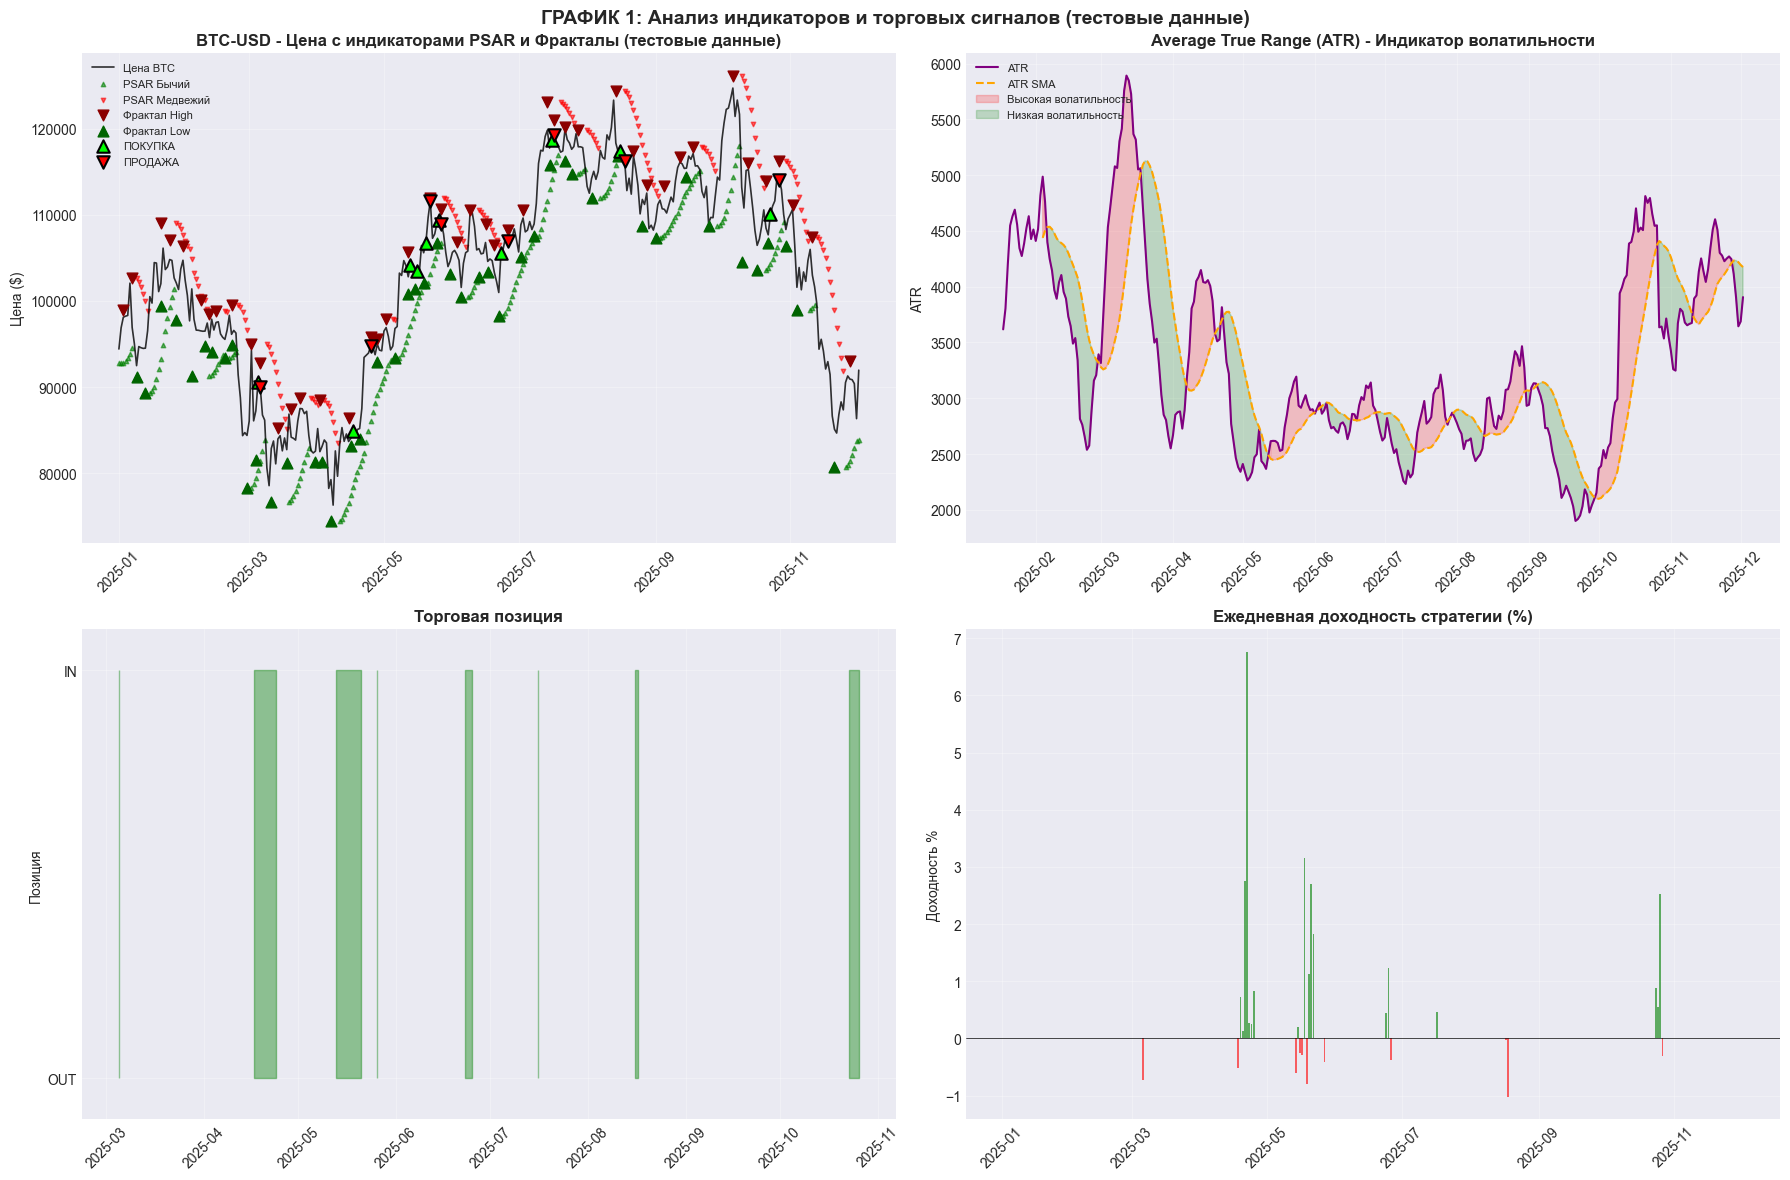

In [9]:
# График 1 для тестовых данных
fig2 = visualizer.plot_indicators_and_signals(results["test"], "(тестовые данные)")
plt.show()

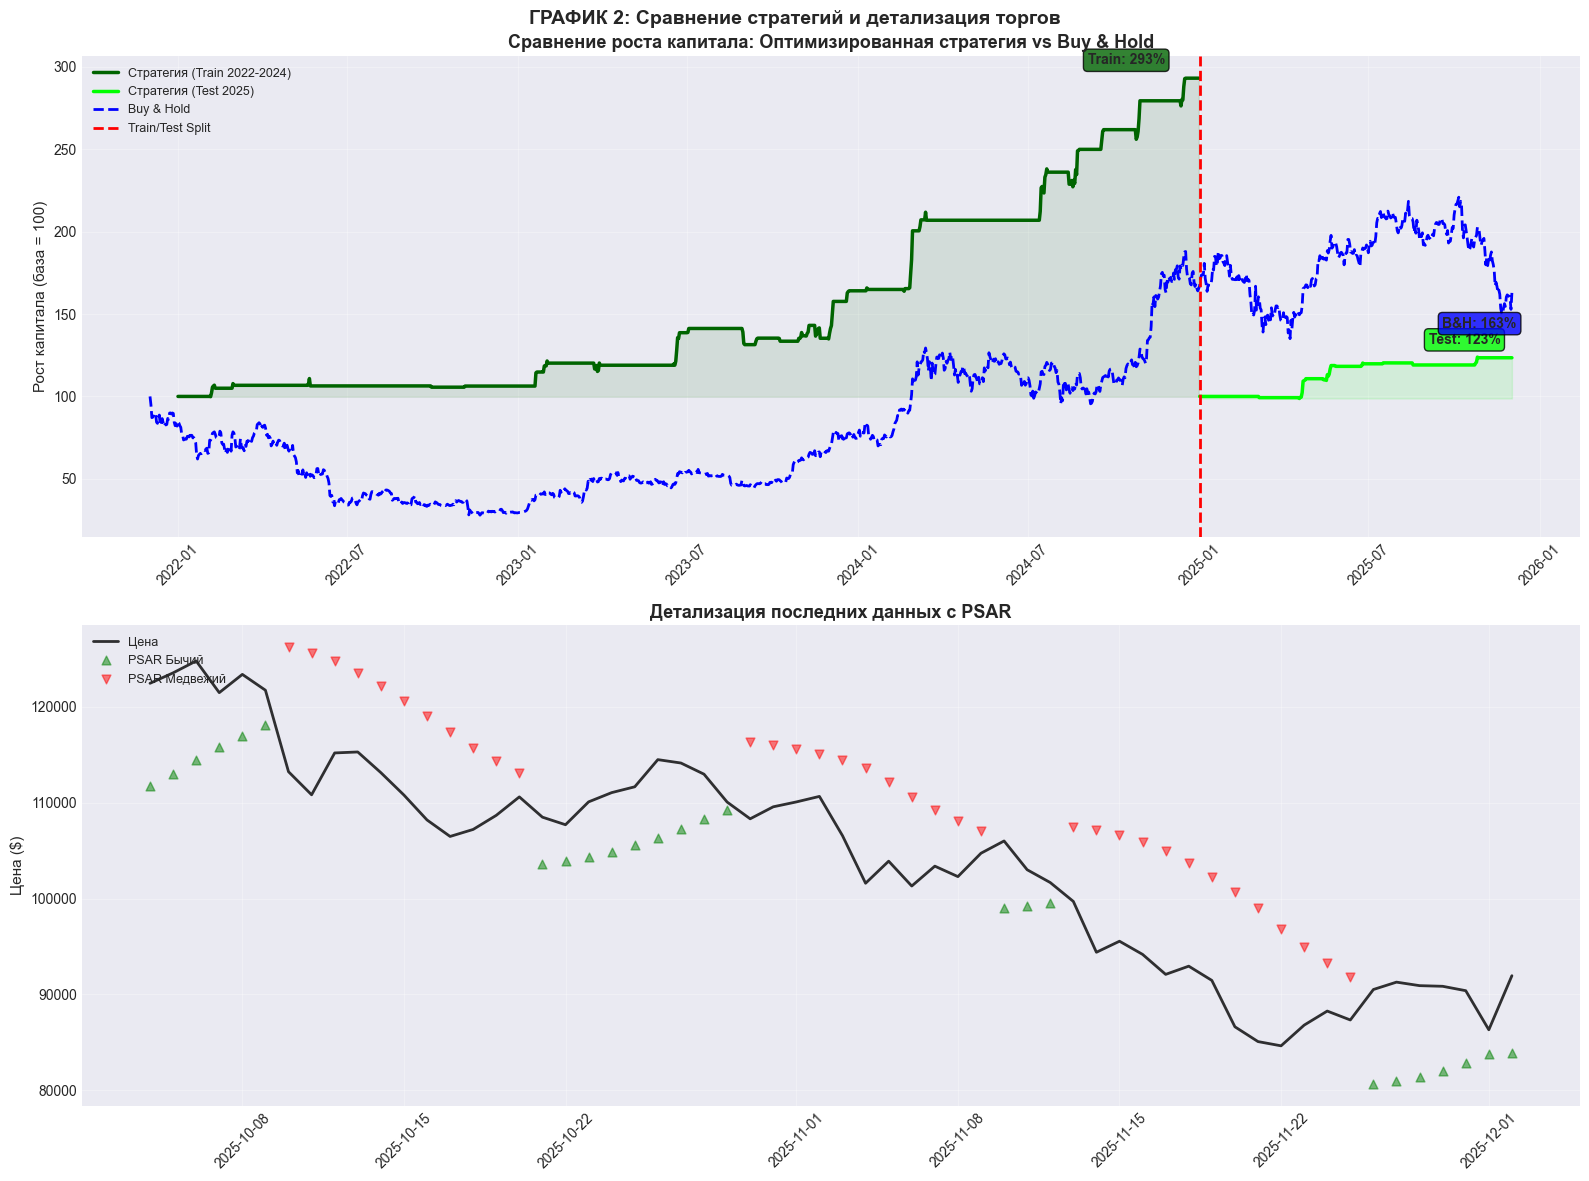

In [10]:
fig = visualizer.plot_strategy_comparison(
    results["train"], results["test"], results["full"], Config.TEST_START
)
plt.show()

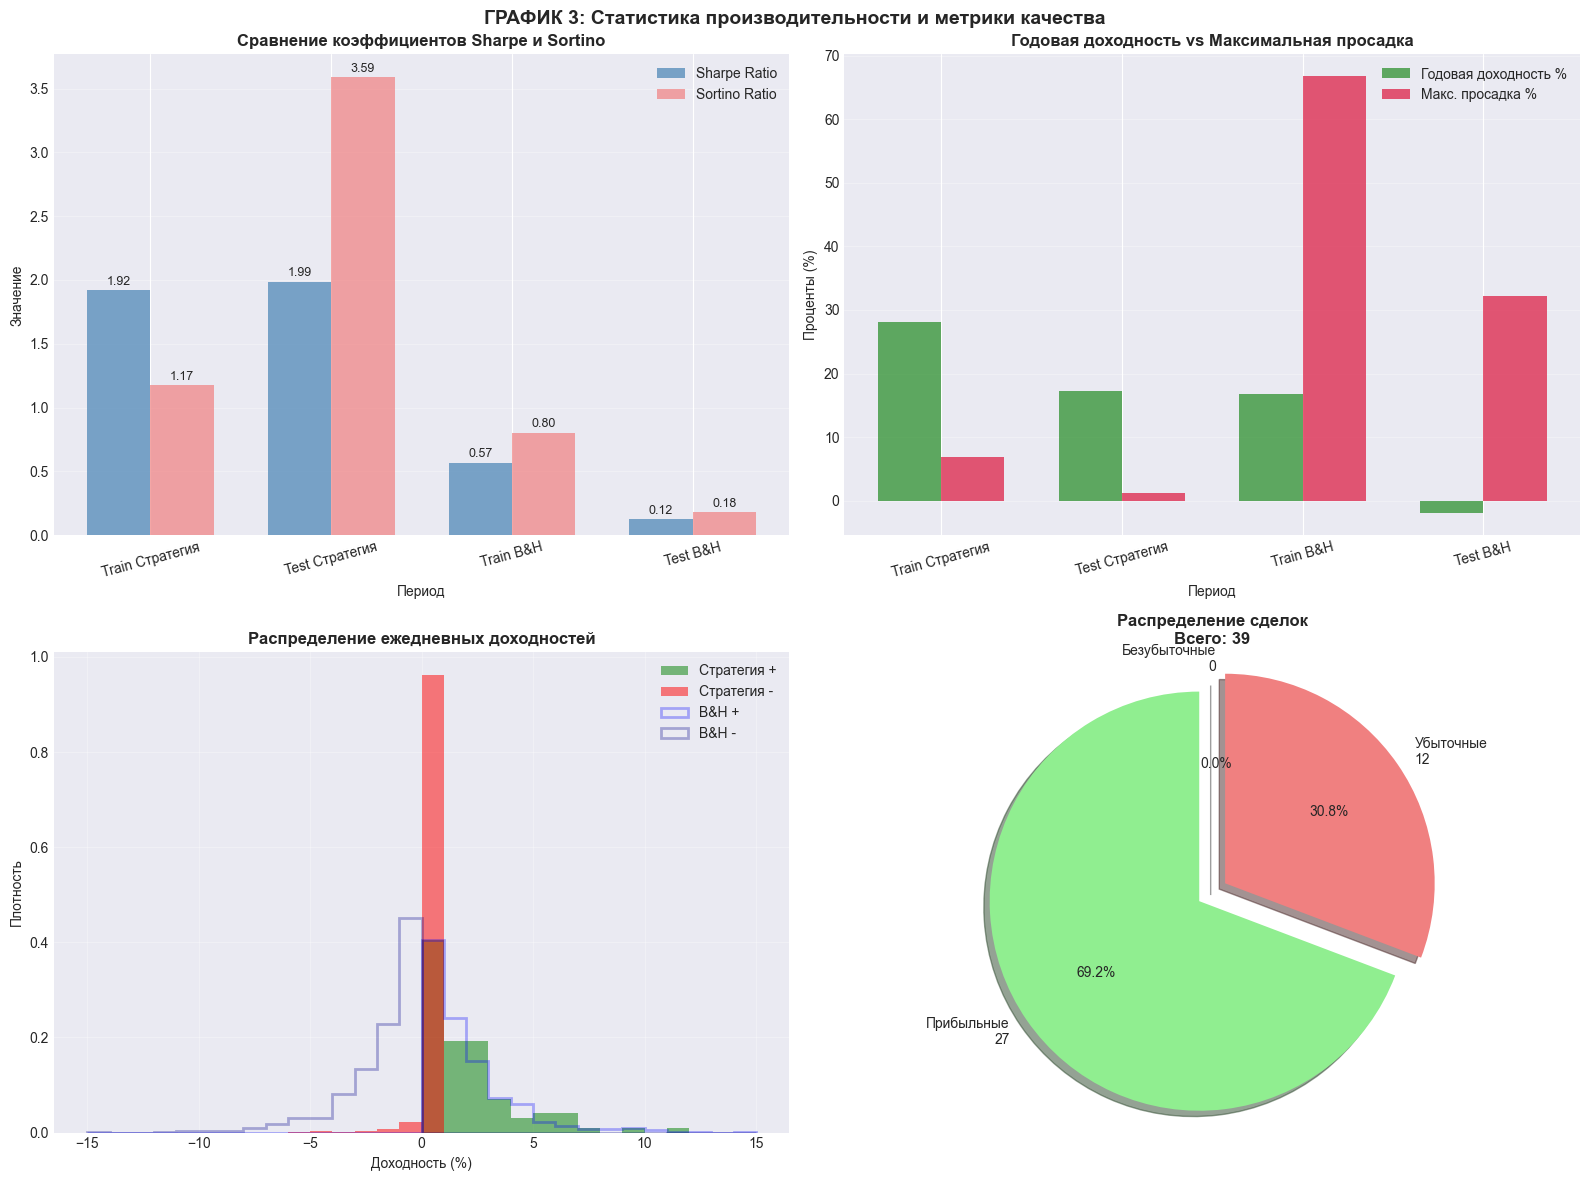


СТАТИСТИКА СДЕЛОК:
   Всего сделок: 39
   Прибыльных: 27 (69.2%)
   Убыточных: 12
   Средняя прибыль: 3.67%
   Максимальная прибыль: 21.20%
   Максимальный убыток: -6.95%


In [11]:
# Расчет метрик
metrics_calculator = PerformanceMetrics()

train_metrics = metrics_calculator.calculate_all_metrics(results["train"]["Strategy_Return"])
test_metrics = metrics_calculator.calculate_all_metrics(results["test"]["Strategy_Return"])
train_bh_metrics = metrics_calculator.calculate_all_metrics(results["train"]["BuyHold_Return"])
test_bh_metrics = metrics_calculator.calculate_all_metrics(results["test"]["BuyHold_Return"])

# Анализ сделок
trade_analysis = metrics_calculator.analyze_trades(trades["full"])

# Визуализация
visualizer = StrategyVisualizer()
fig = visualizer.plot_performance_metrics(
    results["full"],
    trades["full"],
    train_metrics,
    test_metrics,
    train_bh_metrics,
    test_bh_metrics,
)
plt.show()

# Детальная статистика сделок
if trade_analysis:
    print("\nСТАТИСТИКА СДЕЛОК:")
    print(f"   Всего сделок: {trade_analysis['total_trades']}")
    print(
        f"   Прибыльных: {trade_analysis['profitable_trades']} "
        f"({trade_analysis['win_rate']:.1f}%)"
    )
    print(f"   Убыточных: {trade_analysis['losing_trades']}")
    print(f"   Средняя прибыль: {trade_analysis['avg_profit']:.2f}%")
    print(f"   Максимальная прибыль: {trade_analysis['max_profit']:.2f}%")
    print(f"   Максимальный убыток: {trade_analysis['max_loss']:.2f}%")